In [43]:
#initialize environment, load modules/libraries

import os
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

#import python code from seperate files
from helpers.fourier_transform import load_wav, dft_logmag, patches, dft

# load for test purposes
from scipy.io import wavfile

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
music_dir = './data/music_wav'

# music data file names used for testing
music_test = [
    'unpoco.wav',
    'blues.wav',
    'gismonti.wav',
    'ipanema.wav',
    'deedee.wav',
    'hendrix.wav',
    'madradeus.wav',
    'marlene.wav',
    'beatles.wav',
    'bagpipe.wav',
    'redhot.wav',
    'jazz.wav'
]

music_test = [os.path.join(music_dir, file) for file in music_test]

music = [os.path.join(music_dir, file) for file in os.listdir(music_dir) if file.endswith('.wav')]

# create set of audio files without test files
music = list(set(music)-set(music_test))

speech_dir = './data/speech_wav'

# speech data file names used for testing
speech_test = [
    'comedy.wav',
    'thlui.wav',
    'voices.wav',
    'conversion.wav',
    'china.wav',
    'vegetables2.wav',
    'amal.wav',
    'teachers2.wav',
    'chant.wav',
    'pulp2.wav',
    'acomic.wav',
    'kid.wav'
]
speech_test = [os.path.join(speech_dir, file) for file in speech_test]

speech = [os.path.join(speech_dir, file) for file in os.listdir(speech_dir) if file.endswith('.wav')]

# create set of audio files without test files
speech = list(set(speech)-set(speech_test))
	  
print(len(music), len(speech))

52 52


In [3]:
test = speech_test + music_test
test_labels = np.zeros(len(test))
test_labels[0:len(speech_test)]=1

split = len(speech)*8//10

train = speech[:split] + music[:split]
train_labels = np.zeros(len(train))
train_labels[:split]=1

validate = speech[split:] + music[split:]
validate_labels = np.zeros(len(validate))
validate_labels[:len(speech[split:])]=1

In [4]:
test_sounds = load_wav(test)
train_sounds = load_wav(train)
validate_sounds = load_wav(validate)

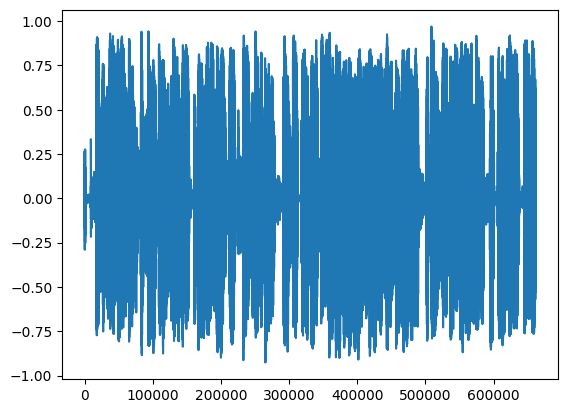

In [5]:
plt.plot(train_sounds[0])
plt.show()

In [6]:
fft_step=256
fft_size=512
fft_chunks = len(train_sounds[0])//fft_step

test_logmag = dft_logmag(test_sounds,fft_chunks,fft_step,fft_size)
train_logmag = dft_logmag(train_sounds,fft_chunks,fft_step,fft_size)
validate_logmag = dft_logmag(validate_sounds,fft_chunks,fft_step,fft_size)

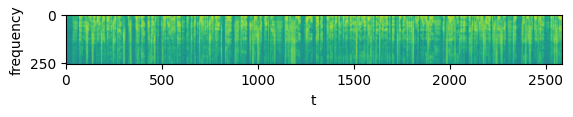

In [7]:
plt.imshow(train_logmag[0].T)
plt.xlabel('t')
plt.ylabel('frequency')
plt.show()

In [8]:
patch_step = 32
patch_size = 64

def ds_window(sound, label, patch_step, patch_size):
    labels = np.ones(len(sound))*label
    sound = np.c_[sound,labels]
    ds = tf.data.Dataset.from_tensor_slices(sound)
    ds = ds.window(size=patch_size,shift=patch_step,drop_remainder=True)
    ds = ds.flat_map(lambda x: x.batch(patch_size))
    return ds

def ds_patches(sounds, labels, patch_step, patch_size):
    ds = ds_window(sounds[0],labels[0],patch_step,patch_size)
    for sound, label in zip(sounds[1:],labels[1:]): ds = ds.concatenate(ds_window(sound,label,patch_step,patch_size))
    ds = ds.map(lambda x: (x[:,:-1], x[0,-1]))
    return ds

test_ds = ds_patches(test_logmag, test_labels, patch_step, patch_size)
train_ds = ds_patches(train_logmag, train_labels, patch_step, patch_size)
validate_ds = ds_patches(validate_logmag, validate_labels, patch_step, patch_size)

n_test = test_logmag.shape[0]*(((test_logmag.shape[1]-patch_size)//patch_step)+1)
n_train = train_logmag.shape[0]*(((train_logmag.shape[1]-patch_size)//patch_step)+1)
n_validate = validate_logmag.shape[0]*(((validate_logmag.shape[1]-patch_size)//patch_step)+1)

print(f"{n_test} samples for test.")
print(f"{n_train} samples for training.")
print(f"{n_validate} samples for validation.")

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-02-21 13:14:47.720967: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1896 samples for test.
6478 samples for training.
1738 samples for validation.


In [10]:
n = 10
for sound, label in train_ds.take(n):
    sound = sound.numpy()
    print(f"{sound.shape} : {sound[[0,patch_step],0]} : {sound[[-patch_step-1,-1],0]}")

(64, 256) : [-5.02746974 -7.18733348] : [-5.63278375 -4.52927379]
(64, 256) : [-7.18733348 -5.67787224] : [-4.52927379 -7.71701187]
(64, 256) : [-5.67787224 -5.7202553 ] : [-7.71701187 -8.15708882]
(64, 256) : [-5.7202553  -5.38302183] : [-8.15708882 -5.21061838]
(64, 256) : [-5.38302183 -4.80630588] : [-5.21061838 -4.99599569]
(64, 256) : [-4.80630588 -4.61208816] : [-4.99599569 -4.53308064]
(64, 256) : [-4.61208816 -5.32335701] : [-4.53308064 -5.21387294]
(64, 256) : [-5.32335701 -4.13886559] : [-5.21387294 -4.76621251]
(64, 256) : [-4.13886559 -3.45022889] : [-4.76621251 -5.59891204]
(64, 256) : [-3.45022889 -5.10475699] : [-5.59891204 -5.62482728]


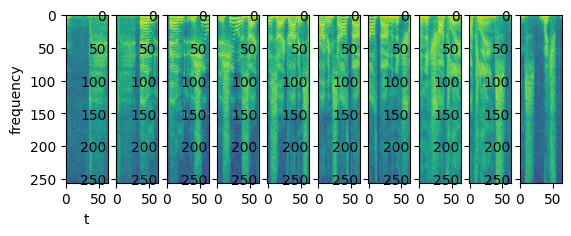

In [12]:
for i, (sound, label) in enumerate(train_ds.take(n)):
    plt.subplot(1,n,i+1)
    plt.imshow(sound.numpy().T)
    if i == 0:
        plt.xlabel('t')
        plt.ylabel('frequency')
plt.show()

In [46]:
test_ds = test_ds.shuffle(n_test)
train_ds = train_ds.shuffle(n_train)
validate_ds = validate_ds.shuffle(n_validate)

test_x = test_ds.map(lambda x, y: x)
test_y = test_ds.map(lambda x, y: y)

train_x = train_ds.map(lambda x, y: x)
train_y = train_ds.map(lambda x, y: y)

validate_x = validate_ds.map(lambda x, y: x)
validate_y = validate_ds.map(lambda x, y: y)

print(f"Samples are shuffled now ... {[int(label.numpy()) for label in test_y.take(20)]} ...")

Samples are shuffled now ... [1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0] ...


In [70]:
# Convert the train and test datasets to NumPy arrays
train_x_np = np.asarray(list(map(lambda x: x[0], tfds.as_numpy(train_ds))))
train_y_np = np.asarray(list(map(lambda x: x[1], tfds.as_numpy(train_ds))))

validate_x_np = np.asarray(list(map(lambda x: x[0], tfds.as_numpy(validate_ds))))
validate_y_np = np.asarray(list(map(lambda x: x[1], tfds.as_numpy(validate_ds))))
validate_y_np


array([1., 0., 1., ..., 1., 1., 0.])

In [67]:
# Define the input shape of the images
input_shape = (64, 256, 1)

# Define the model architecture
model = tf.keras.Sequential([
    
    # First convolutional layer
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    
    # Second convolutional layer
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    
    # Third convolutional layer
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    
    # Fourth convolutional layer
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    
    # Flatten the output of the convolutional layers
    tf.keras.layers.Flatten(),
    
    # First fully connected layer
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    
    # Second fully connected layer
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 62, 254, 32)       320       
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 31, 127, 32)      0         
 g2D)                                                            
                                                                 
 batch_normalization_65 (Bat  (None, 31, 127, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_57 (Conv2D)          (None, 29, 125, 64)       18496     
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 14, 62, 64)       0         
 g2D)                                                            
                                                     

In [68]:
# Define the model architecture
model2 = tf.keras.models.Sequential([
    # First convolutional layer
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, activation='relu', input_shape=input_shape),
    # Second convolutional layer
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, activation='relu'),
    # Third convolutional layer
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, activation='relu'),
    # Fourth convolutional layer
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=2, activation='relu'),
    # Flatten the output of the convolutional layers
    tf.keras.layers.Flatten(),
    # First fully connected layer
    tf.keras.layers.Dense(units=512, activation='relu'),
    # Second fully connected layer (output layer)
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Compile the model
model2.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model2.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 31, 127, 32)       320       
                                                                 
 conv2d_61 (Conv2D)          (None, 15, 63, 64)        18496     
                                                                 
 conv2d_62 (Conv2D)          (None, 7, 31, 128)        73856     
                                                                 
 conv2d_63 (Conv2D)          (None, 3, 15, 256)        295168    
                                                                 
 flatten_15 (Flatten)        (None, 11520)             0         
                                                                 
 dense_30 (Dense)            (None, 512)               5898752   
                                                                 
 dense_31 (Dense)            (None, 1)               

In [69]:
save_path = '../save/mnist_{epoch}.ckpt'
save_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path, save_weights_only=True)

hist = model2.fit(x=train_x_np, y=train_y_np,
          epochs=10, batch_size=64, 
          validation_data=(validate_x_np, validate_y_np))

Epoch 1/10
102/102 [==============================] - 18s 166ms/step - loss: 0.8174 - accuracy: 0.4992 - val_loss: 0.6931 - val_accuracy: 0.4994
Epoch 2/10
102/102 [==============================] - 16s 162ms/step - loss: 0.6934 - accuracy: 0.5062 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 3/10
102/102 [==============================] - 16s 161ms/step - loss: 0.6932 - accuracy: 0.5063 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/10
 54/102 [==============>...............] - ETA: 7s - loss: 0.6932 - accuracy: 0.5041

KeyboardInterrupt: 

In [58]:
train_x_np.shape[1:]

(64, 256)